## Multi-Class Classification with Perceptron

### Prepare the data

In [2]:
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os
import gzip

# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(1)
import random


#### import the data

In [3]:

with gzip.open("../mnist.pkl.gz", "rb") as f:
    MNIST = pickle.load(f, encoding="latin1")  # or encoding="bytes"

# unpack once
(train_set, valid_set, test_set) = MNIST

# rebuild the structure the notebook assumes
MNIST = {
    "Train": {
        "Features": train_set[0],
        "Labels": train_set[1],
    },
    "Validation": {
        "Features": valid_set[0],
        "Labels": valid_set[1],
    },
    "Test": {
        "Features": test_set[0],
        "Labels": test_set[1],
    },
}

#### plot the data

In [ ]:
print(MNIST['Train']['Features'][0][130:180])
print(MNIST['Train']['Labels'][0])
features = MNIST['Train']['Features'].astype(np.float32) / 256.0
labels = MNIST['Train']['Labels']
fig = pylab.figure(figsize=(10, 5))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    pylab.imshow(features[i].reshape(28, 28))
pylab.show()

#### get the positive and negative data

In [6]:
def set_mnist_pos_neg(positive_label, negative_label):
    positive_indices = [i for i, j in enumerate(MNIST['Train']['Labels'])
                        if j == positive_label]
    negative_indices = [i for i, j in enumerate(MNIST['Train']['Labels'])
                        if j == negative_label]

    positive_images = MNIST['Train']['Features'][positive_indices]
    negative_images = MNIST['Train']['Features'][negative_indices]

    fig = pylab.figure()
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(positive_images[0].reshape(28, 28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    pylab.imshow(negative_images[0].reshape(28, 28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.show()

    return positive_images, negative_images

### train the model

In [83]:
def train_graph(weights, positive_examples, negative_examples, num_iterations=100):
    if len(weights) == 0:
        num_dims = positive_examples.shape[1]
        weights = np.zeros((num_dims, 1))  # initialize weights

    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]

    report_frequency = 15
    snapshots = []

    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)
        if z < 0:
            weights = weights + pos.reshape(weights.shape)

        z = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)

        if i % report_frequency == 0:
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            # make correction a list so it is homogeneous to weights list then numpy array accepts
            snapshots.append((weights.flatten(), (pos_correct + neg_correct) / 2.0))

    return np.array(snapshots, dtype=object)  # Use dtype=object for mixed types

In [27]:
def plotit2(snapshots_mn, step):
    fig = pylab.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(snapshots_mn[step][0].reshape(28, 28), interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.colorbar()
    ax = fig.add_subplot(1, 2, 2)
    ax.set_ylim([0, 1])
    pylab.plot(np.arange(len(snapshots_mn[:, 1])), snapshots_mn[:, 1])
    pylab.plot(step, snapshots_mn[step, 1], "bo")
    pylab.show()


def pl3(step): plotit2(snapshots_mn, step)

#### train classifier for 1 vs 0

In [ ]:
pos1, neg1 = set_mnist_pos_neg(1, 0)
snapshots_mn = train_graph(pos1, neg1, 1000)
interact(pl3, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn) - 1))

In [75]:
cal_weights_1_vs_0 = snapshots_mn[len(snapshots_mn) -1 ][0]
print(cal_weights_1_vs_0)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.98437500e-01  9.96093750e-01
  1.28906250e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

#### train classifier for 1 vs 2

In [77]:
cal_weights = []
pos_digit = 1
neg_digit = 0
print('Skipping current digit:', neg_digit, ', because it equals pos_digit', pos_digit)

Skipping current digit: 0 , because it equals pos_digit 1


#### train this digit vs. all other digits

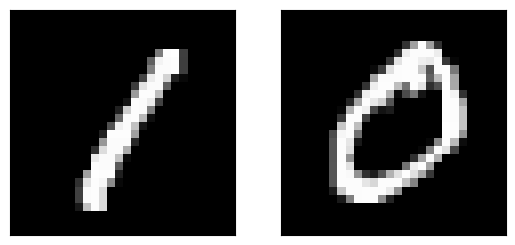

Skipping current digit: 1 , because it equals pos_digit 1


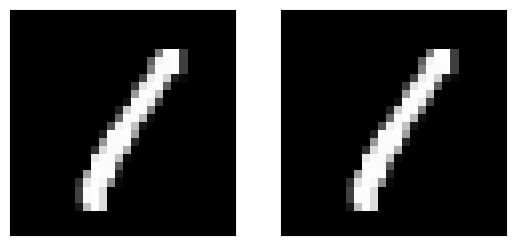

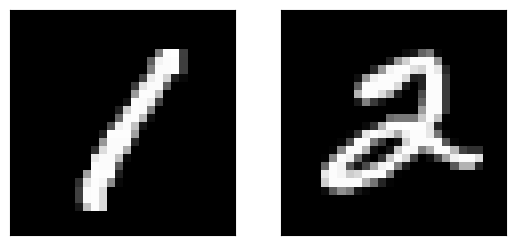

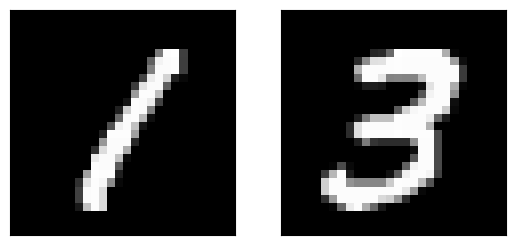

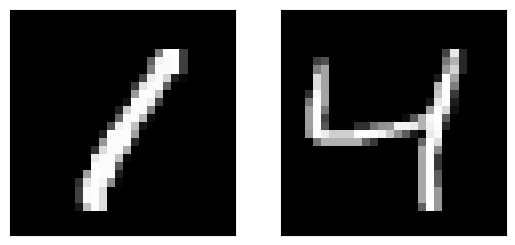

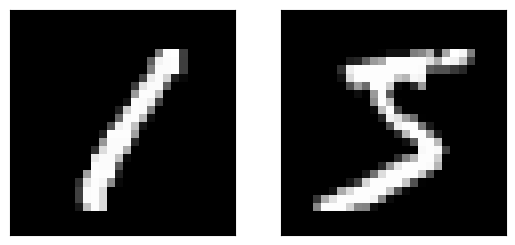

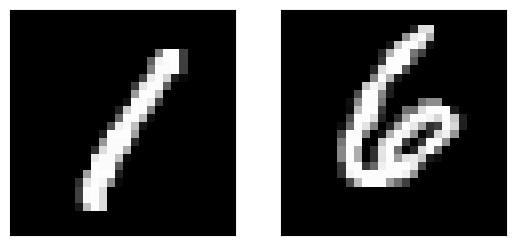

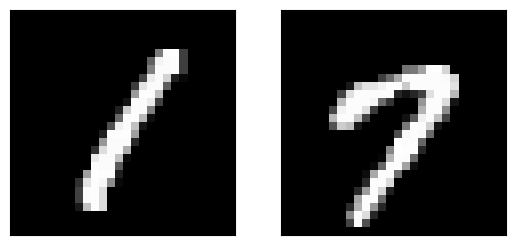

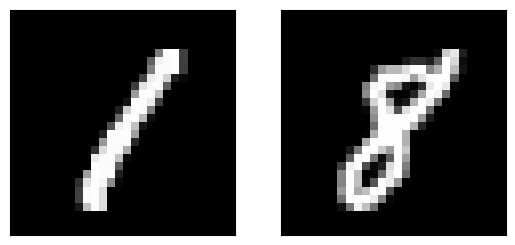

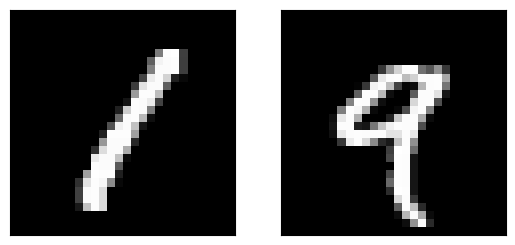

In [84]:
cal_weights = []
pos_digit = 1
neg_digit = 0
while True:
    pos_img, neg_img = set_mnist_pos_neg(pos_digit, neg_digit)
    train_result = train_graph(cal_weights, pos_img, neg_img, 1000)
    cal_weights = train_result[len(train_result) - 1][0]
    neg_digit += 1
    if neg_digit == pos_digit:
        print('Skipping current digit:', neg_digit, ', because it equals pos_digit', pos_digit)
        continue
    if neg_digit > 9:
        break

In [ ]:
pos1, neg1 = set_mnist_pos_neg(1, 2)
snapshots_mn = train_graph(cal_weights_1_vs_0, pos1, neg1, 1000)
interact(pl3, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn) - 1))
cal_weights_1_vs_2 = snapshots_mn[66][0]

### Utility functions

In [37]:
# show_image function to display an image with its label
def show_image(image, label):
    fig = pylab.figure(figsize=(2, 2))
    ax = fig.add_subplot(1, 1, 1)
    pylab.imshow(image.reshape(28, 28), cmap='gray', interpolation='nearest')
    ax.set_title('Image is: ' + str(label))
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.show()

In [33]:
# Function to get a random test data point
def random_get_test_data():
    random_index = random.randint(0, len(MNIST['Test']['Features']) - 1)
    return MNIST['Test']['Features'][random_index], MNIST['Test']['Labels'][random_index]

In [ ]:
random_test_image, random_test_label = random_get_test_data()
print("Random Test Image Label: ", random_test_label)
show_image(random_test_image, random_test_label)
# random_test_data = random.choice(MNIST['Train']['Features'])
# print(random_test_data)
# show_image(random_test_data)

### Predict the labels

In [85]:
print(cal_weights)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.51562500e-01
 -9.60937500e-01 -4.57031250e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

#### manually check the prediction

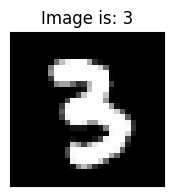

Is this data 1:  False


In [102]:
test_image, test_label = random_get_test_data()
show_image(test_image, test_label)
z = np.dot(test_image, cal_weights)
if z >= 0:
    predicted = True
else:
    predicted = False
print("Is this data 1: ", predicted)

#### batch prediction

In [103]:
incorrect_count = 0
incorrect_images = []
for i in range(100):
    test_image, test_label = random_get_test_data()
    z = np.dot(test_image, cal_weights)
    if z >= 0:
        predicted = True
    else:
        incorrect_count += 1
        incorrect_images.append([test_image, test_label])
print("Is this data 1? Test 100 times. The accuracy is: ", incorrect_count / len(incorrect_images))

Is this data 1? Test 100 times. The accuracy is:  1.0


In [95]:
len(MNIST['Test']['Features'])

10000